In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import missingno as msno
from geopy.geocoders import Nominatim
import folium
from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import os

In [2]:
# from google.colab import drive 
# drive.mount('/content/drive')

In [3]:
# df = pd.read_csv('/content/drive/MyDrive/Zomato/zomato.csv')
df = pd.read_csv('zomato.csv')

In [4]:
df.drop_duplicates(inplace=True)
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


In [6]:
df.iloc[0]

url                            https://www.zomato.com/bangalore/jalsa-banasha...
address                        942, 21st Main Road, 2nd Stage, Banashankari, ...
name                                                                       Jalsa
online_order                                                                 Yes
book_table                                                                   Yes
rate                                                                       4.1/5
votes                                                                        775
phone                                             080 42297555\r\n+91 9743772233
location                                                            Banashankari
rest_type                                                          Casual Dining
dish_liked                     Pasta, Lunch Buffet, Masala Papad, Paneer Laja...
cuisines                                          North Indian, Mughlai, Chinese
approx_cost(for two people) 

In [8]:
df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [9]:
df = df[~df['rate'].isnull()]

In [10]:
df.shape

(43942, 17)

In [11]:
df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                               0
votes                              0
phone                            832
location                           0
rest_type                        151
dish_liked                     20333
cuisines                          11
approx_cost(for two people)      252
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [12]:
df = df[~(df['rate'] == 'NEW')]

In [13]:
df.shape

(41734, 17)

In [14]:
df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                               0
votes                              0
phone                            818
location                           0
rest_type                        149
dish_liked                     18272
cuisines                          11
approx_cost(for two people)      251
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [15]:
df = df[~(df['rate'] == '-')]

In [16]:
df = df[~df['approx_cost(for two people)'].isnull()]

In [17]:
df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                               0
votes                              0
phone                            578
location                           0
rest_type                        147
dish_liked                     18091
cuisines                           8
approx_cost(for two people)        0
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [18]:
df = df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type','listed_in(city)':'city'})

df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'cost',
       'reviews_list', 'menu_item', 'type', 'city'],
      dtype='object')

In [19]:
top20rest = df['name'].value_counts()[:20]
top20rest.values

array([86, 85, 69, 68, 68, 67, 62, 60, 60, 60, 59, 59, 59, 59, 58, 58, 56,
       56, 55, 54], dtype=int64)

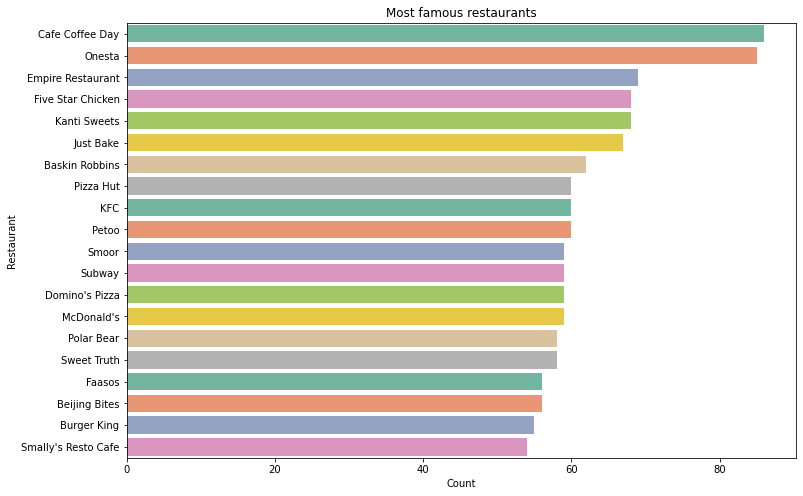

In [20]:
plt.figure(figsize=(12, 8))
sns.barplot(x=top20rest.values, y=top20rest.index, data=df, orient='h', palette='Set2')

plt.xlabel('Count')
plt.ylabel('Restaurant')
plt.title('Most famous restaurants')
# plt.savefig('./application/client/src/images/stats/most-famous-rest.png')

plt.show()

In [21]:
book_table = df['book_table'].value_counts()/df.shape[0]

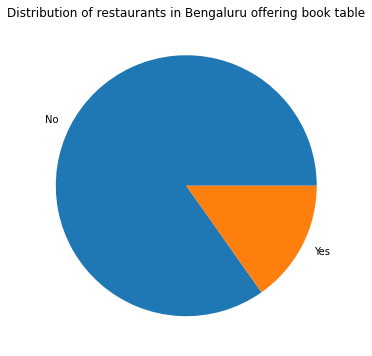

In [22]:
plt.figure(figsize=(8,6))
plt.pie(book_table, labels=book_table.index)
plt.title('Distribution of restaurants in Bengaluru offering book table')
# plt.savefig('./application/client/src/images/stats/book-table.png')

plt.show()

## North-South cuisines

In [23]:
north = df[df['cuisines'].str.contains('North', na=False, case=False)].shape[0]
south = df[df['cuisines'].str.contains('South', na=False, case=False)].shape[0]

In [24]:
south

6379

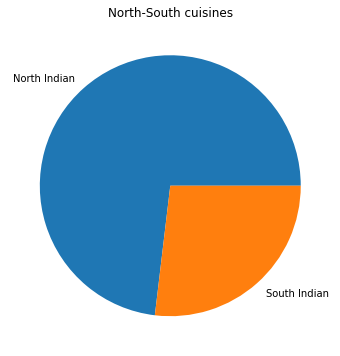

In [25]:
plt.figure(figsize=(8,6))
plt.pie([north, south], labels=['North Indian', 'South Indian'])
plt.title('North-South cuisines')
# plt.savefig('./application/client/src/images/stats/north-south-pie.png')

plt.show()

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rate', ylabel='Density'>

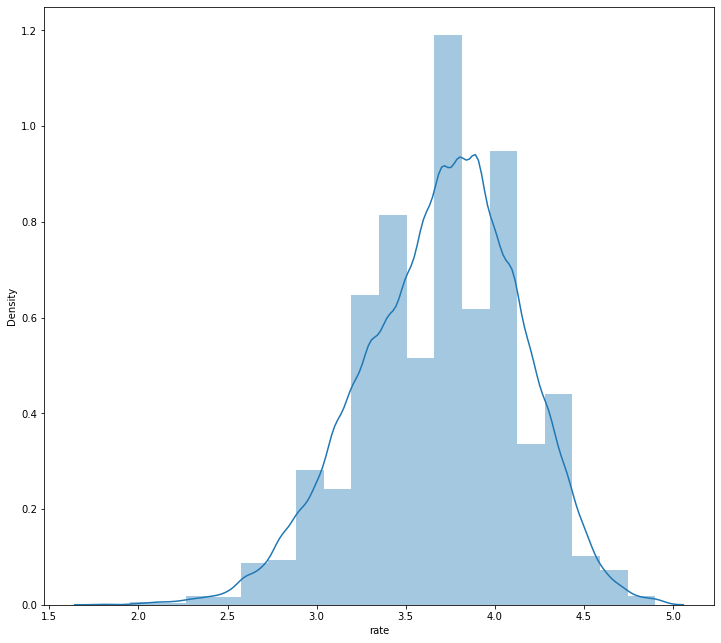

In [26]:
plt.figure(figsize=(12,11))
rate = df['rate'].apply(lambda x:float(x.split('/')[0]))
sns.distplot(rate, bins=20)

## Cost vs Rating

In [27]:
c = df['cost'].dropna()
cost = c.apply(lambda x:int(x.replace(',','')))

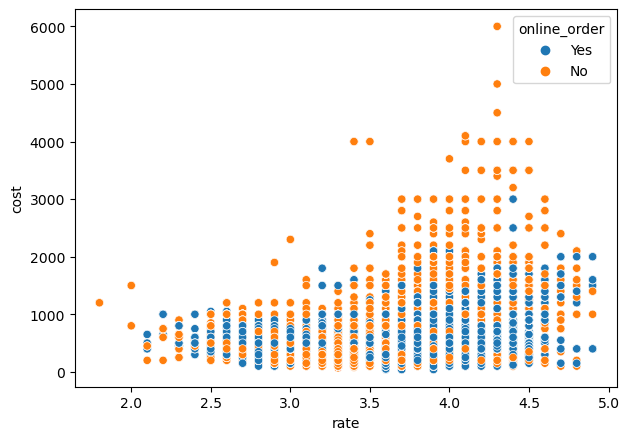

In [28]:
plt.figure(figsize=(7,5),dpi=100)

sns.scatterplot(x=rate,y=cost, hue='online_order', data=df)

plt.show()

E:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cost', ylabel='Density'>

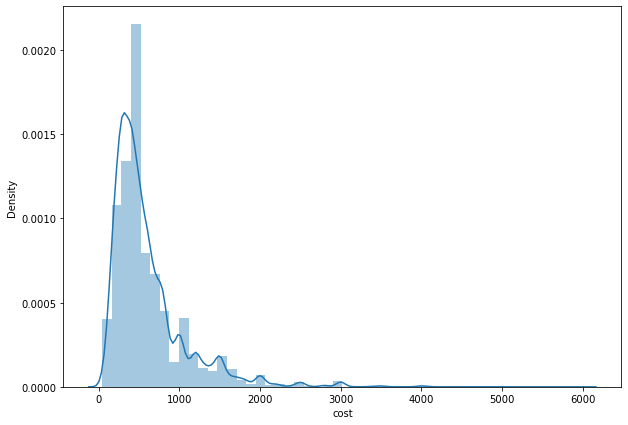

In [29]:
plt.figure(figsize=(10,7))
sns.distplot(cost)

## Votes vs Online order

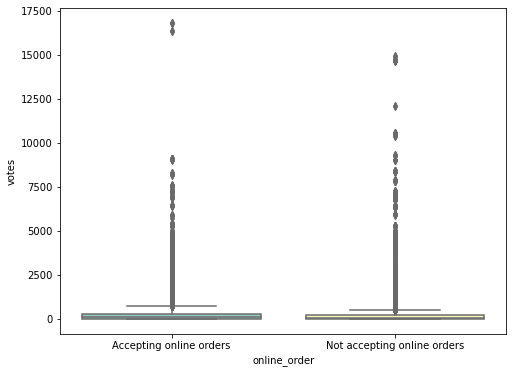

In [30]:
plt.figure(figsize=(8,6))
col = df['online_order']
col = col.replace({'Yes':'Accepting online orders', 'No':'Not accepting online orders'})
sns.boxplot(x = col, y='votes', data=df, palette='Set3')
plt.show()

## Top 20 restaurant types in Bengaluru

In [31]:
to20rest_type = df['rest_type'].value_counts()[:20]

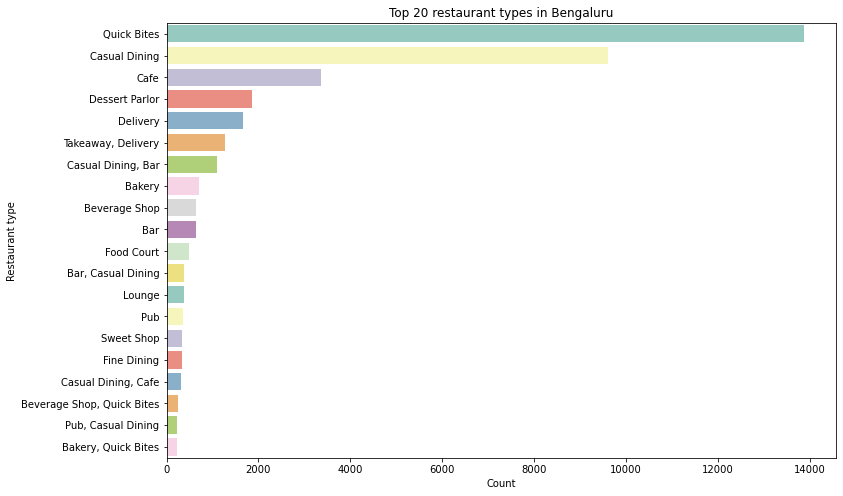

In [32]:
plt.figure(figsize=(12,8))

sns.barplot(x=to20rest_type.values, y=to20rest_type.index, orient='h', palette='Set3')

plt.xlabel('Count')
plt.ylabel('Restaurant type')
plt.title('Top 20 restaurant types in Bengaluru')
# plt.savefig('./application/client/src/images/stats/most-famous-rest-types.png')
plt.show()

## Cost factor for restaurants accepting online order

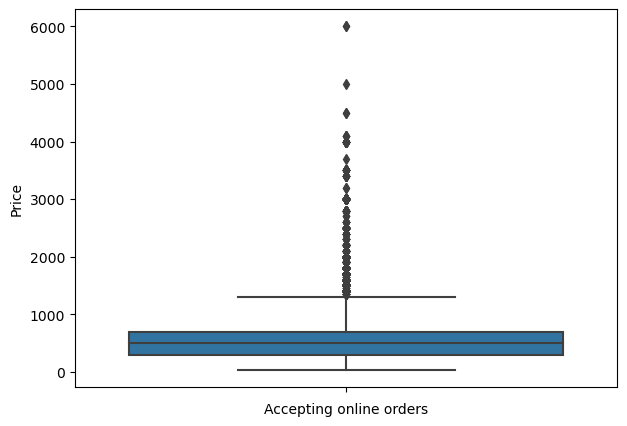

In [33]:
plt.figure(figsize=(7, 5), dpi=100)
sns.boxplot(y = cost)
plt.ylabel('Price')
plt.xlabel('Accepting online orders')
plt.show()

## Top areas in Bengaluru for food

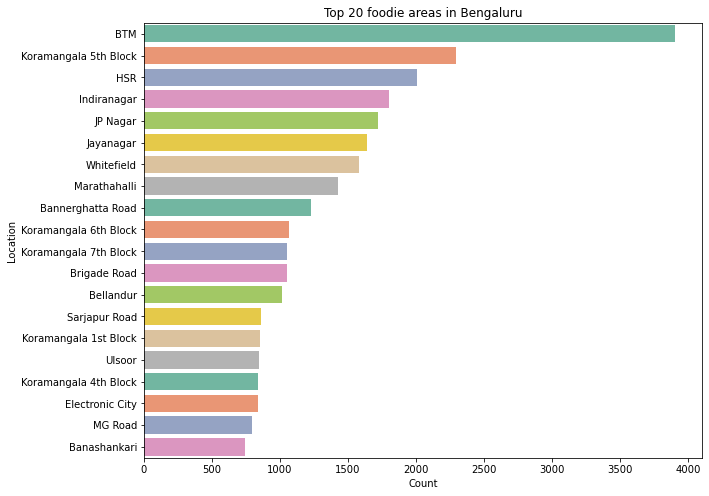

In [34]:
plt.figure(figsize=(10, 8))

rest_locations = df['location'].value_counts()[:20]
sns.barplot(x=rest_locations.values, y=rest_locations.index, orient='h', palette='Set2')

plt.ylabel('Location')
plt.xlabel('Count')
plt.title('Top 20 foodie areas in Bengaluru')
# plt.savefig('./application/client/src/images/stats/top-foodie-areas.png')
plt.show()

## Converting cost column to float type

In [35]:
df['cost'] = df['cost'].str.replace(',', '')
df['cost'] = df['cost'].astype(int)

In [36]:
#Replacing all the zeroes with 
# df['col1'] = df['col1'].replace(0, mean_non_zero)
# df['cost'].isnull().sum()
df.head(1)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari


## Finding best budget restaurant in any area

In [37]:
def best_rest(location, rest_type, cost):
    return df[(df['location'] == location) & (df['rest_type'].str.contains(rest_type)) & (df['cost'] <= cost)].sort_values(by=['rate'], ascending=False)[['name','address','rate','phone','rest_type','cuisines','location','cost']].drop_duplicates(subset='name')
# ,'address','rate','phone','rest_type','cuisines','location','cost'

In [38]:
best_rest('Banashankari', 'Cafe', 300)

,name,address,rate,phone,rest_type,cuisines,location,cost
18,T3H Cafe,"504, CJ Venkata Das Road, Padmanabhangar, 2nd ...",3.9/5,+91 8884726600,Cafe,"Cafe, Italian, American",Banashankari,300
26,Coffee Tindi,"27th Cross Rd, Banashankari Stage II, Banashan...",3.8/5,+91 9945758046,"Cafe, Quick Bites","Cafe, South Indian",Banashankari,200
24,Hide Out Cafe,"775/1, Opposite Gupta Collage, 7th Block, 3rd ...",3.7/5,+91 9901481185,Cafe,Cafe,Banashankari,300


## Most famous cuisines in Bengaluru

In [39]:
df_1=df.groupby(['location','cuisines']).agg('count')
data_cuisines_loc=df_1.sort_values(['url'],ascending=False).groupby(['location'],
                as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [40]:
data_cuisines_loc.head(10)

,level_0,location,cuisines,count
0,0,BTM,"North Indian, Chinese",342
1,0,BTM,North Indian,241
2,0,BTM,Fast Food,104
3,1,Banashankari,"North Indian, Chinese",60
4,1,Banashankari,South Indian,55
5,1,Banashankari,North Indian,27
6,2,Banaswadi,South Indian,27
7,2,Banaswadi,"North Indian, Chinese",18
8,2,Banaswadi,Biryani,15
9,3,Bannerghatta Road,"North Indian, Chinese",114


## Extracting location information using Geopy

In [41]:
# location = pd.DataFrame({'Name': df['location'].unique()})
# location['Name'] = location['Name'].apply(lambda x: "Bangalore, " + str(x))

# lat_lon = []
# geolocator = Nominatim(user_agent="geoapiExercises")
# for name in location['Name']:
#     loc = geolocator.geocode(name)
#     if loc is None:
#         lat_lon.append('None')
#     else:
#         lat_lon.append((loc.latitude, loc.longitude))
        
# location['geo_loc'] = lat_lon

In [42]:
# location.to_csv('locations.csv', index=False)

## Heatmap of restaurant count on each location

In [43]:
# locations = pd.read_csv('/content/drive/MyDrive/Zomato/locations.csv')
locations = pd.read_csv('locations.csv')

In [44]:
locations.head()

,Name,geo_loc
0,"Bangalore, Banashankari","(12.965283249999999, 77.59445195)"
1,"Bangalore, Basavanagudi","(12.9417261, 77.5755021)"
2,"Bangalore, Mysore Road","(12.9467026, 77.5300705)"
3,"Bangalore, Jayanagar","(12.9292731, 77.5824229)"
4,"Bangalore, Kumaraswamy Layout","(12.9081487, 77.5553179)"


In [45]:
locations = locations[~(locations['geo_loc'] == 'None')]

In [46]:
locations['latitude'] = locations['geo_loc'].apply(lambda x: float(x[1:-1].split(',')[0]))
locations['longitude'] = locations['geo_loc'].apply(lambda x: float(x[1:-1].split(',')[1]))

In [47]:
locations = locations.drop(['geo_loc'], axis=1)

In [48]:
m = folium.Map(location=[locations['latitude'].mean(), locations['longitude'].mean()], zoom_start=13)

In [49]:
# folium.plugins.HeatMap(data=locations[['latitude', 'longitude']].values.tolist(), radius=8, max_zoom=13).add_to(m)

In [50]:
m.save('heatmap.html')
m

## Which are the most popular cuisines in Bengaluru

In [51]:
cuisines = df[df['cuisines'].notnull()]['cuisines'].value_counts()[:20]

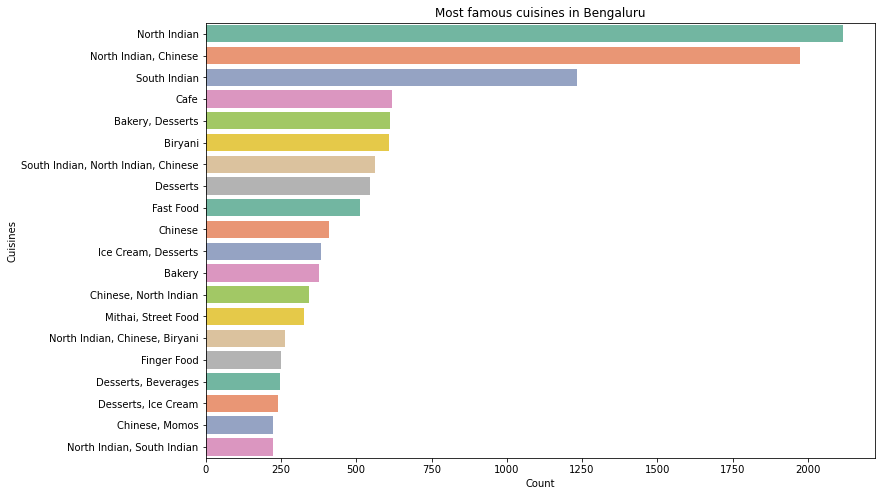

In [52]:
plt.figure(figsize=(12, 8))
sns.barplot(x=cuisines.values, y=cuisines.index, orient='h', palette='Set2')

plt.xlabel('Count')
plt.ylabel('Cuisines')
plt.title('Most famous cuisines in Bengaluru')

# plt.savefig('./application/client/src/images/stats/most-popular-cuisines.png')

plt.show()

## Hotspot of North Indian restaurant

In [53]:
def produce_data(cuisine):
    cuisines = df[df['cuisines'].notnull()][['cuisines','location']]
    return cuisines[(cuisines['cuisines'].str.contains(cuisine))].reset_index()

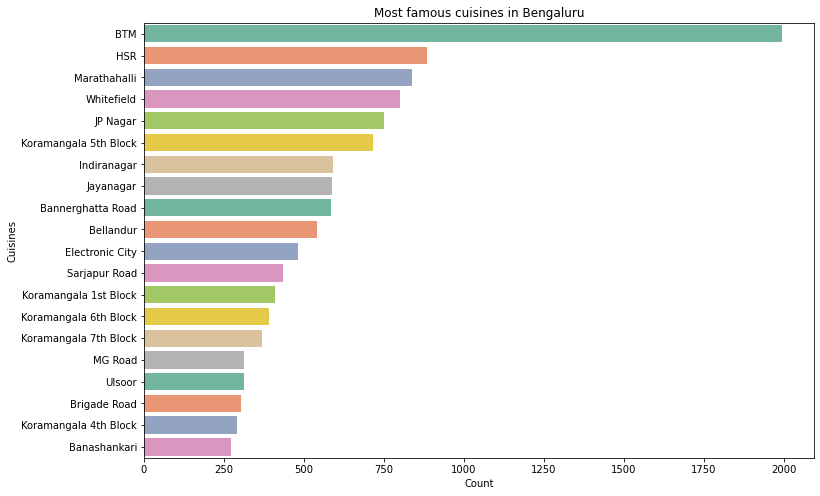

In [55]:
hotspot = produce_data('North')['location'].value_counts()[:20]

plt.figure(figsize=(12, 8))
sns.barplot(x=hotspot.values, y=hotspot.index, orient='h', palette='Set2')

plt.xlabel('Count')
plt.ylabel('Cuisines')
plt.title('Most famous cuisines in Bengaluru')

# plt.savefig('./application/client/src/images/stats/north-hotspot.png')

plt.show()

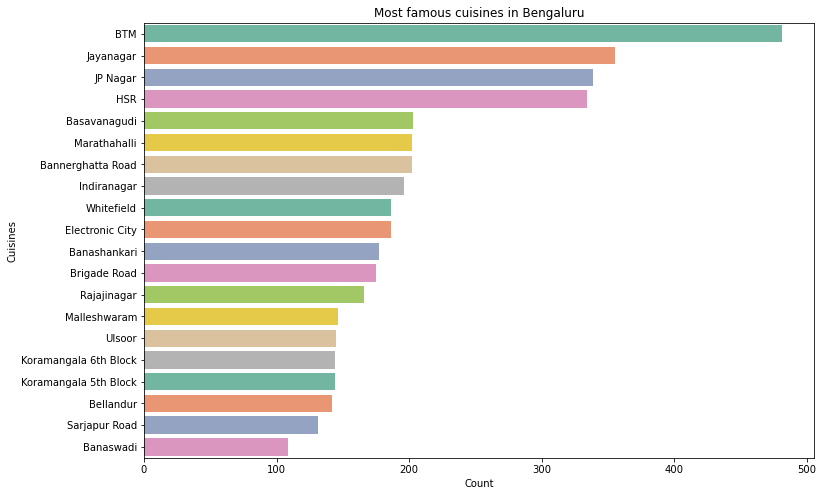

In [56]:
hotspot = produce_data('South')['location'].value_counts()[:20]

plt.figure(figsize=(12, 8))
sns.barplot(x=hotspot.values, y=hotspot.index, orient='h', palette='Set2')

plt.xlabel('Count')
plt.ylabel('Cuisines')
plt.title('Most famous cuisines in Bengaluru')

# plt.savefig('./application/client/src/images/stats/south-hotspot.png')

plt.show()

## Analysing restaurant chains

In [57]:
df_1=df.groupby(['rest_type','name']).agg('count')
data=df_1.sort_values(['url'],ascending=False).groupby(['rest_type'], as_index=False).apply(lambda x : x.sort_values(by="url",ascending=False).head(3))['url'].reset_index().rename(columns={'url':'count'})

In [58]:
data

,level_0,rest_type,name,count
0,0,Bakery,Just Bake,43
1,0,Bakery,INDULGE by InnerChef,28
2,0,Bakery,Warm Oven,28
3,1,"Bakery, Beverage Shop",Bake The Cake,1
4,2,"Bakery, Cafe",Glen's Bakehouse,30
...,...,...,...,...
202,85,Takeaway,TheRiceBowl.In,8
203,85,Takeaway,Mount View Fast Food,7
204,86,"Takeaway, Delivery",The Good Bowl,28
205,86,"Takeaway, Delivery",BOX8- Desi Meals,27


## Which are most popular casual dining restaurant?

In [15]:
def most_famous_rest_type(type):
  casual = data[data['rest_type'].str.contains(type)].sort_values(by=['count'], ascending=False).head(5)
  return casual

In [16]:
most_famous_rest_type('Irani Cafee')

NameError: name 'data' is not defined

In [11]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [68]:
import pickle

In [80]:
# pickle.dump(data, open('../server/most_famous_rest_type.pkl', 'wb'))
data['rest_type'].unique()

array(['Bakery', 'Bakery, Beverage Shop', 'Bakery, Cafe',
       'Bakery, Dessert Parlor', 'Bakery, Food Court',
       'Bakery, Quick Bites', 'Bar', 'Bar, Casual Dining', 'Bar, Lounge',
       'Bar, Pub', 'Bar, Quick Bites', 'Beverage Shop',
       'Beverage Shop, Cafe', 'Beverage Shop, Dessert Parlor',
       'Beverage Shop, Quick Bites', 'Bhojanalya', 'Cafe', 'Cafe, Bakery',
       'Cafe, Bar', 'Cafe, Casual Dining', 'Cafe, Dessert Parlor',
       'Cafe, Food Court', 'Cafe, Lounge', 'Cafe, Quick Bites',
       'Casual Dining', 'Casual Dining, Bar', 'Casual Dining, Cafe',
       'Casual Dining, Irani Cafee', 'Casual Dining, Lounge',
       'Casual Dining, Microbrewery', 'Casual Dining, Pub',
       'Casual Dining, Quick Bites', 'Casual Dining, Sweet Shop', 'Club',
       'Club, Casual Dining', 'Confectionery', 'Delivery',
       'Dessert Parlor', 'Dessert Parlor, Bakery',
       'Dessert Parlor, Beverage Shop', 'Dessert Parlor, Cafe',
       'Dessert Parlor, Food Court', 'Dessert Par

## Analysing Reviews

In [61]:
# all_rating = []
# regex = r'\(\'Rated.*?\)'

# for i in tqdm(df.index):
#     split_string = re.findall(regex, df['reviews_list'][i][1:-1])
#     for rating in split_string:
#         if rating:
#             all_rating.append([df['name'][i], rating[8:11], rating[23:-2]])
# # df['reviews_list'][0][1:-1]

In [62]:
# all_rating[:1]

In [63]:
# rating_df = pd.DataFrame(all_rating,columns=['name','rating','review'])
# rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))

In [64]:
# rating_df.head()

In [65]:
# rating_df.to_csv('Ratings.csv')

In [66]:
# rating_df = pd.read_csv('/content/drive/MyDrive/Zomato/Ratings.csv')
rating_df = pd.read_csv('Ratings.csv')

In [67]:
rating_df = rating_df.drop(['Unnamed: 0'], axis=1)
rating_df.head()

,name,rating,review
0,Jalsa,4.0,A beautiful place to dine inThe interiors tak...
1,Jalsa,4.0,I was here for dinner with my family on a wee...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me ...
3,Jalsa,4.0,We went here on a weekend and one of us had t...
4,Jalsa,5.0,The best thing about the place is itx83x83x82...


## Wordcloud of reviews of restaurants chain

In [68]:
rating_df.isnull().sum()

name         0
rating       0
review    2328
dtype: int64

In [69]:
rating_df.dropna(how='any', inplace=True)

In [70]:
rating_df.isnull().sum()

name      0
rating    0
review    0
dtype: int64

In [71]:
def produceCloud(rest):
  reviews = " ".join(review for review in rating_df[rating_df['name'].apply(lambda x: x.lower()) == rest.lower()]['review'])
  wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(reviews)
                       
  plt.figure(figsize = (6, 6), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  plt.show()

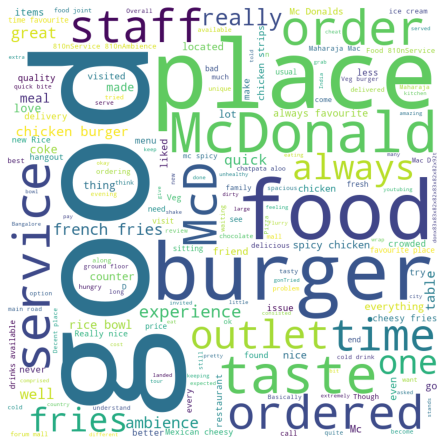

In [72]:
produceCloud("Mcdonald's")

## Rating Distribution

In [107]:
def produceRatingDist(rest):
  rating = rating_df[rating_df['name'].apply(lambda x: x.lower()) == rest.lower()]['rating'].value_counts()
  plt.figure(figsize=(9, 6))
  sns.barplot(x = rating.index, y = rating.values)
  plt.xlabel('Rating')
  plt.ylabel('Count')
#   plt.savefig('./application/client/src/images/stats/rating-distribution.png')

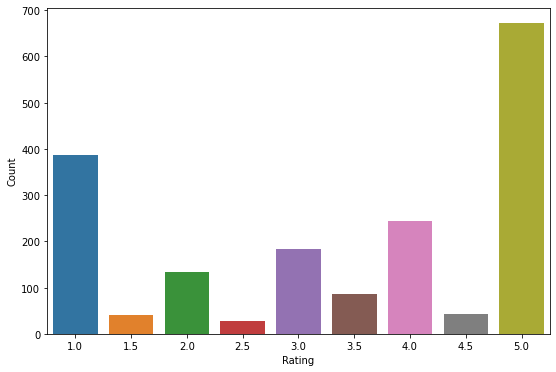

In [108]:
rest = 'pizza huT'
produceRatingDist(rest)

## Data transformation

In [76]:
df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


In [68]:
# Transforming rate column in df data frame
df['rate'] = df['rate'].apply(lambda x: x.replace(' ',''))
df['rate'] = df['rate'].apply(lambda x: float(x[:-2]))
df['rate'].unique()

array([4.1, 3.8, 3.7, 3.6, 4.6, 4. , 4.2, 3.9, 3.1, 3. , 3.2, 3.3, 2.8,
       4.4, 4.3, 2.9, 3.5, 2.6, 3.4, 4.5, 2.5, 2.7, 4.7, 2.4, 2.2, 2.3,
       4.8, 4.9, 2.1, 2. , 1.8])

In [69]:
df.name = df.name.apply(lambda x:x.title())
df.online_order.replace(('Yes', 'No'), (True, False), inplace=True)
df.book_table.replace(('Yes', 'No'), (True, False), inplace=True)
df.cost.unique()

array([ 800,  300,  600,  700,  550,  500,  450,  650,  400,  900,  200,
        750,  150,  850,  100, 1200,  350,  250,  950, 1000, 1500, 1300,
        199, 1100, 1600,  230,  130, 1700, 1350, 2200, 1400, 2000, 1800,
       1900,  180,  330, 2500, 2100, 3000, 2800, 3400,   50,   40, 1250,
       3500, 4000, 2400, 2600, 1450,   70, 3200,  240, 6000, 1050, 2300,
       4100,  120, 5000, 3700, 1650, 2700, 4500,   80])

In [70]:
df.isnull().sum()

url                 0
address             0
name                0
online_order        0
book_table          0
rate                0
votes               0
phone             578
location            0
rest_type         147
dish_liked      18091
cuisines            8
cost                0
reviews_list        0
menu_item           0
type                0
city                0
dtype: int64

In [71]:
restaurants = list(df['name'].unique())
df['Mean Rating'] = 0

for restaurant in restaurants:
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mean Rating'][df['name'] == restaurant] = df[df['name'] == restaurant]['rate'].mean()
C:\Users\Aditya Bhardwaj\AppData\Local\Temp\ipykernel_14172\521696096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [72]:
df.head(1)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,True,True,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,4.118182


In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1, 5))
df[['Mean Rating']] = scaler.fit_transform(df[['Mean Rating']]).round(2)

df.sample(3)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
24874,https://www.zomato.com/bangalore/asia-in-a-box...,"21, 2nd Cross, 3rd Main, Kirthi Layout, Kachar...",Asia In A Box,True,False,3.0,16,080 41606452\r\n080 41606454,Kammanahalli,Casual Dining,NaN,"Thai, Vietnamese, Indonesian, Asian",550,"[('Rated 1.0', 'RATED\n The beef rendang was ...",[],Dine-out,Kalyan Nagar,2.67
38509,https://www.zomato.com/bangalore/minimelts-bri...,"5th, Avenue Mall, Brigade Road, Bangalore",Minimelts,False,False,3.9,66,080 41225834,Brigade Road,Dessert Parlor,NaN,Ice Cream,200,"[('Rated 4.0', 'RATED\n At the entrance of fi...",[],Desserts,Lavelle Road,3.71
8465,https://www.zomato.com/bangalore/the-biriyani-...,"3rd Cross Road, Venkateshwara Layout, Suddagun...",The Biriyani Pedia,True,False,3.9,56,+91 9809202588,BTM,Quick Bites,"Chicken Stew, Ghee Rice, Chai, Beef Biryani",Biryani,300,"[('Rated 5.0', ""RATED\n Quite easy on the poc...",[],Delivery,BTM,3.75


## Text preprocessing

1. Converting into lower case
2. Removal of punctuations, stopwords and URLs
3. Spelling correction

In [74]:
# df[['reviews_list', 'cuisines']].head(2)

In [75]:
# Converting to lower case
# df['reviews_list'] = df['reviews_list'].apply(lambda x: x.lower())
# df[['reviews_list', 'cuisines']].head(2)

In [76]:
# pip install --user -U nltk

In [77]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
import string

In [78]:
# download the necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Aditya
[nltk_data]     Bhardwaj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aditya
[nltk_data]     Bhardwaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aditya
[nltk_data]     Bhardwaj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Aditya
[nltk_data]     Bhardwaj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [79]:
# create a function to remove punctuation, stopwords, and URLs
def preprocess_text(text):
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    y = []
    
    for i in text.split():
        y.append(ps.stem(i))

    text = ' '.join(y)
    
    return text

In [80]:
# apply the preprocess_text function to the 'reviews_list' column of the DataFrame
# df['reviews_list'] = df['reviews_list'].apply(preprocess_text)

In [81]:
# df[['reviews_list', 'cuisines']].head()

## Text vectorization

In [82]:
# processed_review = df[['reviews_list', 'cuisines']]

In [83]:
# processed_review.to_csv('/content/drive/MyDrive/Zomato/ProcessedReview.csv')

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [85]:
data = df.copy()

In [86]:
# data = data.drop(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'cost', 'city', 'Mean Rating'], axis=1)

In [87]:
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,True,True,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,3.99
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,True,False,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,3.97
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,True,False,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,3.58
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,False,False,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,3.45
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,False,False,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,3.58


In [88]:
data.isnull().sum()

url                 0
address             0
name                0
online_order        0
book_table          0
rate                0
votes               0
phone             578
location            0
rest_type         147
dish_liked      18091
cuisines            8
cost                0
reviews_list        0
menu_item           0
type                0
city                0
Mean Rating         0
dtype: int64

In [89]:
data['menu_item'] = data['menu_item'].apply(lambda x: x[1:-1])

In [90]:
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,True,True,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",,Buffet,Banashankari,3.99
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,True,False,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",,Buffet,Banashankari,3.97
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,True,False,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",,Buffet,Banashankari,3.58
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,False,False,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",,Buffet,Banashankari,3.45
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,False,False,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",,Buffet,Banashankari,3.58


In [91]:
data.isnull().sum()

url                 0
address             0
name                0
online_order        0
book_table          0
rate                0
votes               0
phone             578
location            0
rest_type         147
dish_liked      18091
cuisines            8
cost                0
reviews_list        0
menu_item           0
type                0
city                0
Mean Rating         0
dtype: int64

In [92]:
data['rest_type'] = data['rest_type'].apply(lambda x: '' if pd.isnull(x) else x)

In [93]:
data['dish_liked'] = data['dish_liked'].apply(lambda x: '' if pd.isnull(x) else x)

In [94]:
data['cuisines'] = data['cuisines'].apply(lambda x: '' if pd.isnull(x) else x)

In [95]:
data.isnull().sum()

url               0
address           0
name              0
online_order      0
book_table        0
rate              0
votes             0
phone           578
location          0
rest_type         0
dish_liked        0
cuisines          0
cost              0
reviews_list      0
menu_item         0
type              0
city              0
Mean Rating       0
dtype: int64

In [96]:
original_data = data.copy()
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,True,True,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",,Buffet,Banashankari,3.99
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,True,False,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",,Buffet,Banashankari,3.97
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,True,False,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",,Buffet,Banashankari,3.58
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,False,False,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",,Buffet,Banashankari,3.45
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,False,False,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",,Buffet,Banashankari,3.58


In [97]:
# data['rest_type'] = data['rest_type'].apply(lambda x : x.split(','))
# data['dish_liked'] = data['dish_liked'].apply(lambda x: x.split(','))
# data['cuisines'] = data['cuisines'].apply(lambda x: x.split(','))
# data['menu_item'] = data['menu_item'].apply(lambda x: x.split(','))

In [98]:
# data['reviews_list'] = data['reviews_list'].apply(lambda x: x.replace('[\[\]\(\)]', '').split())

In [99]:
# data['rest_type'] = data['rest_type'].apply(lambda x:[i.replace(" ", "") for i in x])
# data['dish_liked'] = data['dish_liked'].apply(lambda x:[i.replace(" ", "") for i in x])
# data['cuisines'] = data['cuisines'].apply(lambda x:[i.replace(" ", "") for i in x])
# data['menu_item'] = data['menu_item'].apply(lambda x:[i.replace(" ", "") for i in x])
# data['reviews_list'] = data['reviews_list'].apply(lambda x:[i.replace(" ", "") for i in x])

In [100]:
# data.head()

In [101]:
# data['type'] = data['type'].apply(lambda x: x.split(','))
# data['type'] = data['type'].apply(lambda x:[i.replace(" ", "") for i in x])

In [102]:
# data['tags'] = data['rest_type']+data['dish_liked']+data['cuisines']+data['reviews_list']+data['menu_item']+data['type']

In [103]:
# data = data.drop(['url','address', 'name', 'city', 'cost', 'Mean Rating', 'online_order', 'book_table', 'rate', 'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines', 'reviews_list', 'menu_item', 'type'], axis = 1)

In [104]:
# data.head()

In [105]:
# data['tags'] = data['tags'].apply(lambda x: " ".join(x))

In [106]:
# data.head()

In [107]:
# data['tags'] = data['tags'].apply(preprocess_text)

In [108]:
# data.to_csv('/content/drive/MyDrive/Zomato/ProcessedTags.csv')

In [110]:
data = pd.read_csv('ProcessedTags.csv')

In [111]:
data.head()

,Unnamed: 0,tags
0,0,casualdin pasta lunchbuffet masalapapad paneer...
1,1,casualdin momo lunchbuffet chocolatenirvana th...
2,2,cafe casualdin churro cannelloni minestronesou...
3,3,quickbit masaladosa southindian northindian [(...
4,4,casualdin panipuri golgapp northindian rajasth...


In [112]:
data = data.drop(['Unnamed: 0'], axis=1)

In [113]:
cv = CountVectorizer(max_features=5000, stop_words='english')

In [ ]:
vectors = cv.fit_transform(data['tags']).toarray()

In [ ]:
vectors.shape

In [114]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity = cosine_similarity(vectors)

In [ ]:
print(data.shape)
print(original_data.shape)
print(vectors.shape)
print(similarity.shape)